<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-258/blob/master/Assignments/Assignment%206/Assignment6partb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification using Pytorch
Dataset: Fashion images

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()



True

# Data Ingestion

In [2]:
mean_gray= 0.1307
stddev_gray= 0.3081
#normalize the image with std and mean
#e.g: input[channel]=(input[channel]-mean[channel])/std(channel)
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset=datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transforms)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# EDA

label: 0


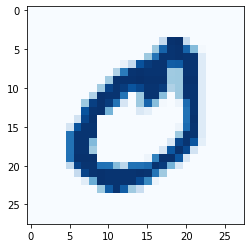

In [8]:
import matplotlib.pyplot as plt
label=train_dataset[21][1]
print('label:', label)
random_image = train_dataset[21][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='Blues')

#Model

In [9]:
#setup dataloaders for train/test

batch_size=100
epochs=10
train_load=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_load=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


In [10]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # layer 1 - CNN, BatchNorm, Relu, MaxPool
    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
      
    # layer 2 - CNN, BatchNorm, Relu, MaxPool
    self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
    )
        
    # layer 3 - Linear, Dropout, Linear, Dropout
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.3)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.drop = nn.Dropout2d(0.3)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.drop(out)
    return out

Hyperparameters:


In [12]:
learning_rate = 0.001
loss_fn=nn.CrossEntropyLoss()
#loss_fn = nn.L1Loss()
momemtum = 0.9

model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momemtum)

#Evaluate

In [13]:
iteration=0
correct_nodata=0
correct_data=0
for i,(inputs,labels) in enumerate (train_load):
  if iteration==1:
    break
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()

  print("For 1 iteration, this is what happens:")
  print(f"Input Shape: {inputs.shape}")
  print(f"Labels Shape: {labels.shape}")
  output = model(inputs)
  
  print(f"Output Shape:{output.shape}")
  _,predicted_nodata=torch.max(output,1)
  
  print(f"Predicted Shape: {predicted_nodata.shape}")
  print(f"Predicted Tensor: {predicted_nodata}")
  correct_nodata +=(predicted_nodata==labels).sum()
  print(f"Correct Predictions: {correct_nodata}")
  _,predicted_data = torch.max(output.data,1)
  correct_data +=(predicted_data==labels.data).sum()
  
  print(f"Correct Predictions: {correct_data}")
  
  iteration+=1

For 1 iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 120])
Predicted Shape: torch.Size([100])
Predicted Tensor: tensor([ 81, 101,   1,  69,  67,  65,  85,   1,  58,  11,  15,  85,   1,  13,
          1,  14,  85,  85,  67,  85,  85,  85,  16,  65,   3,   1,  14,  67,
         85,  85,   1,  27, 114,  85,  85,  85, 106,  22,  96,  69,  95,   1,
        111,  85,  35,  85,  59,  85,  85,  85,  18,  85,  69,  11,  51,  96,
         59,   1,  78,   1,  85,  85,   1,  59,  67,  85, 106,  52,  86, 106,
         69,  85,  69,  59,  35,  18,  85,  69,  85,   1,  35,  85,  82,  65,
        101,  52,  52,  67,  86,  86,  59,  78,  69,  59,   1,  11,   1, 111,
         62,  97], device='cuda:0')
Correct Predictions: tensor(0, device='cuda:0')
Correct Predictions: tensor(0, device='cuda:0')


In [14]:
num_epochs=20

train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]

# Training
for epoch in range(num_epochs):
  # Reset variables at 0 epoch
  correct=0
  iteration=0
  iter_loss=0.0
  
  model.train() # Training Mode
  
  for i,(inputs,labels) in enumerate(train_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    # if CUDA is avaible, shift to GPU (CUDA)
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
      
    optimizer.zero_grad() # clear gradient
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    iter_loss += loss.item() # Accumulate loss
    loss.backward() # backpropagation
    optimizer.step() # update weights
    
    # Save the correct predictions for training data
    _,predicted=torch.max(outputs,1)
    correct +=(predicted==labels).sum()
    iteration +=1
    
  train_loss.append(iter_loss/iteration)
  train_accuracy.append((100*correct/len(train_dataset)))
  
  # Testing
  correct=0
  iteration=0
  loss=0.0
  
  model.eval()  # Testing Mode
  
  for i, (inputs, labels) in enumerate(test_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
    
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss += loss.item()
    
    _,predicted=torch.max(outputs,1)
    correct+=(predicted==labels).sum()
    
    iteration+=1
    
  test_loss.append(loss/iteration)
  test_accuracy.append((100*correct/len(test_dataset)))
  
  print('Epoch {}/{}, Training Loss:{:.3f}, Training Accuracy:{:.3f}, Testing Loss {:.3f}, Testing Accuracy:{:.3f}'
       .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))


Epoch 1/20, Training Loss:1.540, Training Accuracy:65.742, Testing Loss 0.004, Testing Accuracy:96.970
Epoch 2/20, Training Loss:1.241, Training Accuracy:72.362, Testing Loss 0.002, Testing Accuracy:97.870
Epoch 3/20, Training Loss:1.206, Training Accuracy:73.737, Testing Loss 0.001, Testing Accuracy:98.330
Epoch 4/20, Training Loss:1.181, Training Accuracy:74.983, Testing Loss 0.001, Testing Accuracy:98.450
Epoch 5/20, Training Loss:1.174, Training Accuracy:75.465, Testing Loss 0.001, Testing Accuracy:98.500
Epoch 6/20, Training Loss:1.176, Training Accuracy:75.597, Testing Loss 0.001, Testing Accuracy:98.560
Epoch 7/20, Training Loss:1.159, Training Accuracy:76.258, Testing Loss 0.000, Testing Accuracy:98.640
Epoch 8/20, Training Loss:1.154, Training Accuracy:76.598, Testing Loss 0.000, Testing Accuracy:98.640
Epoch 9/20, Training Loss:1.148, Training Accuracy:76.785, Testing Loss 0.000, Testing Accuracy:98.730
Epoch 10/20, Training Loss:1.145, Training Accuracy:76.608, Testing Loss 

#Evaluate

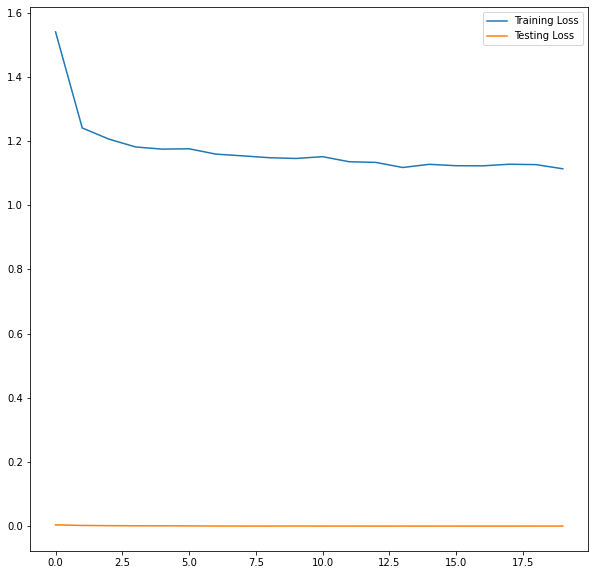

In [15]:
# Loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()


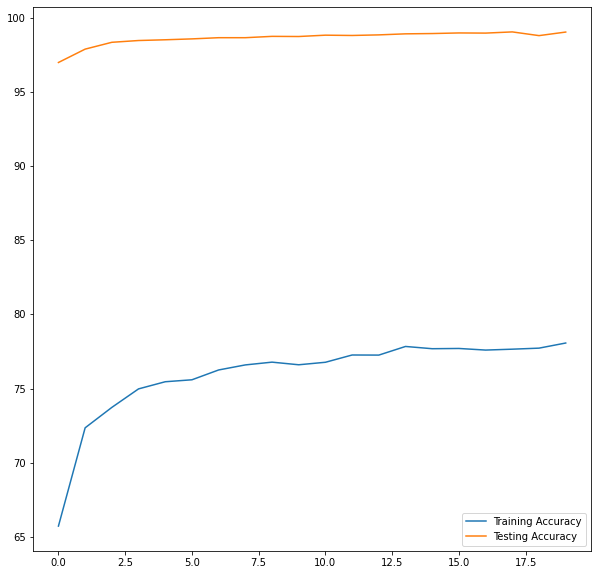

In [16]:
# Accuracy
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [17]:
#Predictions
img= test_dataset[40][0].resize_((1,1,28,28))
img= Variable(img)
label= test_dataset[40][1]

model.eval()

if torch.cuda.is_available():
  model=model.cuda()
  img=img.cuda()
  
output=model(img)
print(output)
print(output.data)
_,predicted=torch.max(output,1)
print("Prediction is:",predicted.item())
print("Actual is:", label)

tensor([[-4.9688,  7.1342, -4.7186, -3.9518, -3.0386, -1.8340, -4.2680, -1.9943,
         -1.0925, -3.1670, -4.3051, -4.2276, -4.2761, -4.4633, -4.2537, -4.0194,
         -4.3856, -4.3918, -4.4933, -4.3329, -4.2829, -4.2102, -4.5793, -4.5850,
         -4.5870, -4.3130, -4.2574, -4.5403, -4.0683, -4.0037, -4.6935, -4.3405,
         -4.4164, -4.3016, -4.3014, -4.1349, -4.2207, -4.5730, -4.3950, -3.7859,
         -4.2198, -4.5133, -4.2992, -4.2731, -4.2520, -4.4658, -4.2202, -4.1471,
         -4.0488, -4.7463, -4.7945, -5.0983, -4.3908, -4.5268, -4.5103, -4.5275,
         -4.4082, -4.2700, -4.2635, -4.5435, -4.6953, -3.9484, -3.9813, -4.4668,
         -4.3467, -4.4676, -4.9060, -4.1321, -4.4584, -4.3266, -4.1345, -4.0821,
         -4.3504, -4.0469, -4.2124, -4.1495, -4.2747, -4.5275, -4.8236, -4.7504,
         -4.5516, -4.0600, -4.0057, -3.9906, -4.0445, -4.3181, -4.2446, -4.2715,
         -4.3147, -4.4481, -4.1309, -4.5952, -3.9974, -4.2644, -4.8488, -4.1759,
         -4.0550, -4.3597, -